In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from lmfit import Minimizer, Parameters, create_params, report_fit, Model
import os
import sys
sys.path.append('../src')
import json

In [2]:
from SQ_KAN import *

## P(Q)

def hardsphere(q, sigma=1):
    R = sigma / 2
    P = (3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2
    return P

def fuzzysphere(q, sigma=1, sigma_f=0.1):
    R = sigma / 2
    P = (3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2 * np.exp(-(sigma_f * sigma * q) ** 2 / 2)
    return P

def log_normal_pdf(mu, sigma, x):
    return np.exp(-(np.log(x) - mu) ** 2 / 2 / sigma ** 2) / x / sigma

def P_HS_eff(q, sigma=1, d_sigma=0.05, return_f=False):
    '''
    sigma: average particle size
    d_sigma: polydispersity
    return_f: toggle whether to return the particle size distribution
    '''
    # List of particle diameter
    n_sample = 101
    sigma_list = (1 + np.linspace(-5, 5, n_sample) * d_sigma) * sigma
    sigma_list = sigma_list[sigma_list > 0]

    # Size distribution
    f_sigma = log_normal_pdf(0, d_sigma, sigma_list / sigma)
    p_sigma = f_sigma * (sigma_list / sigma) ** 6

    # Calculate effective P(Q)
    P_eff = np.zeros_like(q)
    for i in range(len(sigma_list)):
        P_i = hardsphere(q, sigma_list[i]) * p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff / np.sum(p_sigma)

    if return_f:
        return P_eff, sigma_list, f_sigma
    else:
        return P_eff
    
def P_fuzzy_eff(q, sigma, d_sigma):
    P_eff = fuzzysphere(q, sigma, d_sigma)
    return P_eff

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))
Device set to: cpu
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [3]:
def cov_fp(v, q_data, I_data, I_data_err, index_Q):
    Q = q_data
    IQ_rs = I_data
    IQ_er_rs = I_data_err
    delta = 0.05
    x_list = 1 + np.linspace(-5,5,7)*delta
    phi_list = x_list*v['phi']
    kappa_list = x_list*v['kappa']
    A_list = x_list*v['A']
    fp_center = [v['phi'],v['kappa'],np.log(v['A'])]
    phi_grid, kappa_grid, A_grid = np.meshgrid(phi_list, kappa_list, A_list)
    phi_flat = phi_grid.flatten(order='C')
    kappa_flat = kappa_grid.flatten(order='C')
    A_flat = A_grid.flatten(order='C')
    fp_flat_list = [phi_flat,kappa_flat,np.log(A_flat)]
    
    def IQ_fp(fp, Q):
        Qsigma = Q * v['sigma']

        # structure factor
        S = SQ_KAN(fp, Qsigma, device=device)
        S = savgol_filter(S,7,2)

        # form factor
        P = P_HS_eff(Q, sigma=v['sigma'], d_sigma=v['d_sigma'])

        I = v['C']*S*P + v['I_inc']
        return I

    # calculate likelihood
    likelihood_flat = np.zeros_like(phi_flat)
    for i in np.arange(len(phi_flat)):
        index = np.unravel_index(i, phi_grid.shape)
        fp = [phi_flat[i], kappa_flat[i], np.log(A_flat[i])]
        IQ = IQ_fp(fp, Q)
        # minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/z)**2)/2)
        minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/(np.mean(x))/100)**2)/2)
        likelihood_flat[i] = minimizer_target(IQ[index_Q],IQ_rs[index_Q],IQ_er_rs[index_Q])

    # calculate covariance matrix
    cov = np.zeros([3,3])
    for m in range(3):
        for n in range(3):
            d_m = fp_flat_list[m]-fp_center[m]
            d_n = fp_flat_list[n]-fp_center[n]
            cov[m,n] = np.sum(likelihood_flat*d_m*d_n)/np.sum(likelihood_flat)

    return cov

## load data

In [4]:
def desmear(Q,IQ,IQ_er,sigma_Q,n=1,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    DI_ex = IQ_er
    DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    DI_ex_pos = DI_ex[2*n:]
    DI_ex_neg = DI_ex[:-2*n]
    DI_ex = DI_ex[n:-n]

    DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des, DI_des, Q_des

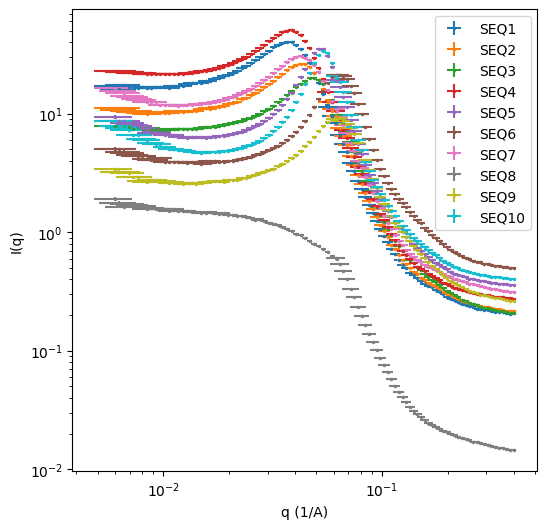

In [5]:
list_seq = ['SEQ1', 'SEQ2', 'SEQ3', 'SEQ4', 'SEQ5', 'SEQ6', 'SEQ7', 'SEQ8', 'SEQ9', 'SEQ10']

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
list_data = []
list_data_des = []
for seq in list_seq:
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-100.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]
    
    I_des, I_des_err, q_des = desmear(q_data, I_data, I_data_err, q_data, n=3, sigmascale=5)
    data_des = np.array([q_des, I_des, I_des_err]).T
    
    list_data.append(data)
    list_data_des.append(data_des)
    
    # ax.errorbar(q_des, I_des, yerr=I_des_err, fmt='-', markersize=3, label=seq)
    ax.errorbar(q_data, I_data, yerr=I_data_err, xerr = q_data_err, fmt='.', markersize=3, label=seq)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
ax.set_xlabel('q (1/A)')
ax.set_ylabel('I(q)')

ax.legend()

results_dict = {}

## SEQ 1

In [6]:
i_seq = 0
seq = list_seq[i_seq]
data = list_data[i_seq]
q_data = data[:, 0]
I_data = data[:, 1]
I_data_err = data[:, 2]
q_data_err = data[:, 3]

scale_q_peak = q_data[np.argmax(I_data)]
sigma_guess = np.pi / scale_q_peak
sigma_min = sigma_guess * 0.4
sigma_max = sigma_guess * 1.6

params = Parameters()
params.add('phi', value=0.056, min=0, max=0.1)
params.add('kappa', value=0.4, min=0.3, max=0.5)
params.add('A', value=8.5, min=7.5, max=10)
params.add('C', value=105, min=100, max=200)
params.add('I_inc', value=0.24, min=0.22, max=0.25)
# params.add('sigma_SQ', value=sigma_guess, min=sigma_min, max=sigma_max)
params.add('sigma', value=sigma_guess, min=sigma_min, max=sigma_max)
params.add('d_sigma', value=0.229, min=0.2, max=0.3)

def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],np.log(v['A'])]
    Qsigma = Q * v['sigma']

    # structure factor
    S = SQ_KAN(fp, Qsigma, device=device)
    S = savgol_filter(S,7,2)

    # form factor
    P = P_HS_eff(Q, sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*S*P + v['I_inc']
    return I

I_test = IQ_th(params, q_data)

q_min = 0.01
q_max = 0.2
index_Q = np.where((q_data>q_min) & (q_data<q_max))[0]

def lmbda(params, Q, IQ_exp, index_Q):
    IQ = IQ_th(params, Q)
    # minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],np.ones_like(IQ_exp))

# do fit, here with the nelder algorithm
minner = Minimizer(lmbda, params, fcn_args=(q_data, I_data, index_Q))
result = minner.minimize('powell')

params_fit = result.params
report_fit(params_fit)

I_test_fit = IQ_th(params_fit, q_data)

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Variables]]
    phi:      0.05940804 +/- 2.6829e-04 (0.45%) (init = 0.056)
    kappa:    0.42335454 +/- 0.00128868 (0.30%) (init = 0.4)
    A:        8.48795135 +/- 0.01768599 (0.21%) (init = 8.5)
    C:        111.942318 +/- 0.73409339 (0.66%) (init = 105)
    I_inc:    0.25000000 +/- 4.5659e-10 (0.00%) (init = 0.24)
    sigma:    82.8484381 +/- 0.08750988 (0.11%) (init = 85.51558)
    d_sigma:  0.24900792 +/- 9.7863e-04 (0.39%) (init = 0.229)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, C)         = +0.9188
    C(C, d_sigma)     = +0.9017
    C(kappa, A)       = -0.7336
    C(phi, d_sigma)   = +0.7178
    C(phi, sigma)     = +0.4194
    C(kappa, d_sigma) = +0.3616
    C(A, d_sigma)     = -0.3117
    C(kappa, sigma)   = -0.2876
    C(A, C)           = -0.2445
    C(kappa, C)       = +0.2285
    C(phi, A)         = -0.2025
    C(A, sigma)       = +0.2011
    C(C, sigma)       = +0.1956
    C(sigma, d_sigma) = -0.1790


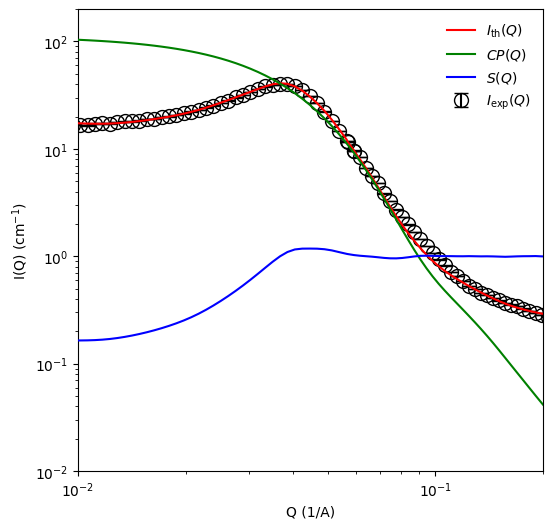

In [8]:
P_fit = P_HS_eff(q_data, sigma=params_fit['sigma'].value, d_sigma=params_fit['d_sigma'].value)* params_fit['C'].value
S_fit = SQ_KAN([params_fit['phi'].value,params_fit['kappa'].value,np.log(params_fit['A'].value)], q_data * params_fit['sigma'].value, device=device)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='ok', markersize=10, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5)
# ax.plot(q_data, I_test, 'k-', label='initial guess')
ax.plot(q_data, I_test_fit, 'r-', label=r'$I_\mathrm{th}(Q)$', zorder=10)
ax.plot(q_data, P_fit, 'g-', label=r'$CP(Q)$', zorder=10)
ax.plot(q_data, S_fit, 'b-', label=r'$S(Q)$', zorder=10)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([q_min,q_max])
ax.set_ylim([1e-2, 2e2])

ax.set_xlabel('Q (1/A)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')
ax.legend(frameon=False)

cov = cov_fp(params_fit.valuesdict(), q_data, I_data, I_data_err, index_Q)

results_dict[seq] = {
    'params_fit': params_fit,
    'I_fit': I_test_fit.tolist(),
    'Q_fit': q_data.tolist(),
    'P_fit': P_fit.tolist(),
    'S_fit': S_fit.tolist(),
    'cov' : cov.tolist()
}

## SEQ 2

In [9]:
i_seq = 1
seq = list_seq[i_seq]
data = list_data[i_seq]
q_data = data[:, 0]
I_data = data[:, 1]
I_data_err = data[:, 2]
q_data_err = data[:, 3]

scale_q_peak = q_data[np.argmax(I_data)]
sigma_guess = np.pi / scale_q_peak
sigma_min = sigma_guess * 0.4
sigma_max = sigma_guess * 1.6

params = Parameters()
params.add('phi', value=0.056, min=0, max=0.15)
params.add('kappa', value=0.4, min=0.2, max=0.5)
params.add('A', value=8.5, min=7, max=10)
params.add('C', value=80, min=50, max=200)
params.add('I_inc', value=0.24, min=0.22, max=0.25)
# params.add('sigma_SQ', value=sigma_guess, min=sigma_min, max=sigma_max)
params.add('sigma', value=sigma_guess, min=sigma_min, max=sigma_max)
params.add('d_sigma', value=0.229, min=0.2, max=0.3)

def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],np.log(v['A'])]
    Qsigma = Q * v['sigma']

    # structure factor
    S = SQ_KAN(fp, Qsigma, device=device)
    S = savgol_filter(S,7,2)

    # form factor
    P = P_HS_eff(Q, sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*S*P + v['I_inc']
    return I

I_test = IQ_th(params, q_data)

q_min = 0.01
q_max = 0.2
index_Q = np.where((q_data>q_min) & (q_data<q_max))[0]

def lmbda(params, Q, IQ_exp, index_Q):
    IQ = IQ_th(params, Q)
    # minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],np.ones_like(IQ_exp))

# do fit, here with the nelder algorithm
minner = Minimizer(lmbda, params, fcn_args=(q_data, I_data, index_Q))
result = minner.minimize('nelder')

params_fit = result.params
report_fit(params_fit)

I_test_fit = IQ_th(params_fit, q_data)

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Variables]]
    phi:      0.06225765 +/- 5.7518e-04 (0.92%) (init = 0.056)
    kappa:    0.47719857 +/- 0.00160653 (0.34%) (init = 0.4)
    A:        8.47681229 +/- 0.01451951 (0.17%) (init = 8.5)
    C:        72.4415741 +/- 0.75671338 (1.04%) (init = 80)
    I_inc:    0.24466541 +/- 0.03174960 (12.98%) (init = 0.24)
    sigma:    74.2291009 +/- 0.15956040 (0.21%) (init = 74.11691)
    d_sigma:  0.24578907 +/- 0.00116025 (0.47%) (init = 0.229)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, C)         = +0.8981
    C(C, d_sigma)     = +0.8590
    C(phi, sigma)     = +0.8412
    C(phi, kappa)     = -0.7260
    C(kappa, sigma)   = -0.6746
    C(phi, d_sigma)   = +0.6324
    C(kappa, C)       = -0.6322
    C(C, sigma)       = +0.6170
    C(kappa, A)       = -0.4082
    C(kappa, d_sigma) = -0.3995
    C(I_inc, sigma)   = +0.3977
    C(A, sigma)       = +0.3306
    C(phi, A)         = +0.2817
    C(phi, I_inc)     = +0.2597
    C(A, C)           = +0.2339
    C(kappa, I

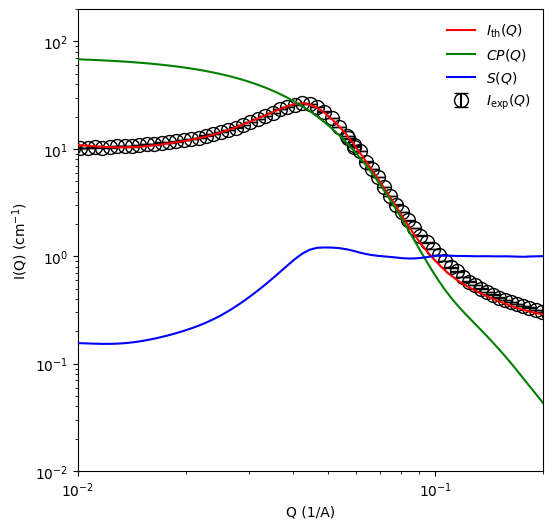

In [10]:
P_fit = P_HS_eff(q_data, sigma=params_fit['sigma'].value, d_sigma=params_fit['d_sigma'].value)* params_fit['C'].value
S_fit = SQ_KAN([params_fit['phi'].value,params_fit['kappa'].value,np.log(params_fit['A'].value)], q_data * params_fit['sigma'].value, device=device)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='ok', markersize=10, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5)
# ax.plot(q_data, I_test, 'k-', label='initial guess')
ax.plot(q_data, I_test_fit, 'r-', label=r'$I_\mathrm{th}(Q)$', zorder=10)
ax.plot(q_data, P_fit, 'g-', label=r'$CP(Q)$', zorder=10)
ax.plot(q_data, S_fit, 'b-', label=r'$S(Q)$', zorder=10)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([q_min,q_max])
ax.set_ylim([1e-2, 2e2])

ax.set_xlabel('Q (1/A)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')
ax.legend(frameon=False)

cov = cov_fp(params_fit.valuesdict(), q_data, I_data, I_data_err, index_Q)

results_dict[seq] = {
    'params_fit': params_fit,
    'I_fit': I_test_fit.tolist(),
    'Q_fit': q_data.tolist(),
    'P_fit': P_fit.tolist(),
    'S_fit': S_fit.tolist(),
    'cov' : cov.tolist()
}

## SEQ 3

In [18]:
i_seq = 2
seq = list_seq[i_seq]
data = list_data[i_seq]
q_data = data[:, 0]
I_data = data[:, 1]
I_data_err = data[:, 2]
q_data_err = data[:, 3]

scale_q_peak = q_data[np.argmax(I_data)]
sigma_guess = np.pi / scale_q_peak
sigma_min = sigma_guess * 0.4
sigma_max = sigma_guess * 1.6

params = Parameters()
params.add('phi', value=0.06, min=0, max=0.15)
params.add('kappa', value=0.4, min=0.2, max=0.5)
params.add('A', value=12, min=10, max=15)
params.add('C', value=50, min=30, max=79)
params.add('I_inc', value=0.25, min=0.22, max=0.28)
# params.add('sigma_SQ', value=sigma_guess, min=sigma_min, max=sigma_max)
params.add('sigma', value=sigma_guess, min=sigma_min, max=sigma_max)
params.add('d_sigma', value=0.229, min=0.2, max=0.3)

def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],np.log(v['A'])]
    Qsigma = Q * v['sigma']

    # structure factor
    S = SQ_KAN(fp, Qsigma, device=device)
    S = savgol_filter(S,7,2)

    # form factor
    P = P_HS_eff(Q, sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*S*P + v['I_inc']
    return I

I_test = IQ_th(params, q_data)

q_min = 0.01
q_max = 0.2
index_Q = np.where((q_data>q_min) & (q_data<q_max))[0]

def lmbda(params, Q, IQ_exp, index_Q):
    IQ = IQ_th(params, Q)
    # minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],np.ones_like(IQ_exp))

# do fit, here with the nelder algorithm
minner = Minimizer(lmbda, params, fcn_args=(q_data, I_data, index_Q))
result = minner.minimize('powell')

params_fit = result.params
report_fit(params_fit)

I_test_fit = IQ_th(params_fit, q_data)

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Variables]]
    phi:      0.05569337 +/- 4.3443e-04 (0.78%) (init = 0.06)
    kappa:    0.45028506 +/- 0.00130604 (0.29%) (init = 0.4)
    A:        14.6409929 +/- 0.01987606 (0.14%) (init = 12)
    C:        49.6639673 +/- 0.48911487 (0.98%) (init = 50)
    I_inc:    0.24728078 +/- 0.04904658 (19.83%) (init = 0.25)
    sigma:    65.1850701 +/- 0.15285688 (0.23%) (init = 64.23762)
    d_sigma:  0.24404953 +/- 0.00134849 (0.55%) (init = 0.229)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, d_sigma)     = +0.8992
    C(phi, sigma)     = +0.8121
    C(kappa, A)       = -0.7119
    C(phi, C)         = +0.6235
    C(I_inc, sigma)   = +0.5693
    C(phi, A)         = +0.4873
    C(I_inc, d_sigma) = -0.4266
    C(A, sigma)       = +0.4259
    C(C, I_inc)       = -0.4178
    C(phi, d_sigma)   = +0.4068
    C(A, C)           = +0.4033
    C(phi, kappa)     = -0.3900
    C(kappa, C)       = -0.3703
    C(phi, I_inc)     = +0.3547
    C(kappa, sigma)   = -0.3012
    C(A, d_sigma

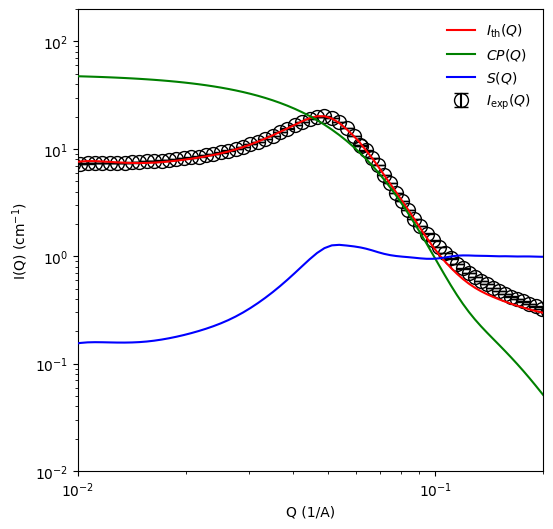

In [19]:
P_fit = P_HS_eff(q_data, sigma=params_fit['sigma'].value, d_sigma=params_fit['d_sigma'].value)* params_fit['C'].value
S_fit = SQ_KAN([params_fit['phi'].value,params_fit['kappa'].value,np.log(params_fit['A'].value)], q_data * params_fit['sigma'].value, device=device)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='ok', markersize=10, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5)
# ax.plot(q_data, I_test, 'k-', label='initial guess')
ax.plot(q_data, I_test_fit, 'r-', label=r'$I_\mathrm{th}(Q)$', zorder=10)
ax.plot(q_data, P_fit, 'g-', label=r'$CP(Q)$', zorder=10)
ax.plot(q_data, S_fit, 'b-', label=r'$S(Q)$', zorder=10)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([q_min,q_max])
ax.set_ylim([1e-2, 2e2])

ax.set_xlabel('Q (1/A)')
ax.set_ylabel('I(Q) (cm$^{-1}$)')
ax.legend(frameon=False)

cov = cov_fp(params_fit.valuesdict(), q_data, I_data, I_data_err, index_Q)

results_dict[seq] = {
    'params_fit': params_fit,
    'I_fit': I_test_fit.tolist(),
    'Q_fit': q_data.tolist(),
    'P_fit': P_fit.tolist(),
    'S_fit': S_fit.tolist(),
    'cov' : cov.tolist()
}

In [20]:
# Convert results_dict to a JSON string
results_json = json.dumps(results_dict, indent=4, default=str)

# Write the JSON string to a text file
with open('results_dict.txt', 'w') as file:
    file.write(results_json)

## Summarizing sequence 1 to 3

In [21]:
def sd_exp_x(mu_x, sigma_x):
    """
    Calculate the standard deviation of exp(x) where x is normally distributed.
    
    Parameters:
    - mu_x: Mean of x
    - sigma_x: Standard deviation of x
    
    Returns:
    - Standard deviation of exp(x)
    """
    # Calculate the expected value of exp(2x) and exp(x)
    exp_2x = np.exp(2 * mu_x + 2 * sigma_x**2)
    exp_x = np.exp(mu_x + 0.5 * sigma_x**2)
    
    # Variance of exp(x)
    var_exp_x = exp_2x - exp_x**2
    
    # Standard deviation is the square root of the variance
    return np.sqrt(var_exp_x)

def sample_potential(fp,fp_err):
    n_sample = 100
    
    kappa = fp[1]
    kappa_std = fp_err[1]
    A = np.exp(fp[2])
    A_std = sd_exp_x(fp[2], fp_err[2])
    
    ur_sample = np.zeros((len(rr),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        A_sample = np.random.normal()*(A_std) + A
        ur_sample[:,i] = A_sample*np.exp(-(rr-1)/kappa_sample)/rr + ur_hc
        
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
        
    return ur_mean, ur_std

def sample_potential_GT(fp):
    kappa = fp[1]
    A = fp[2]
    
    ur = A*np.exp(-(rr-1)/kappa)/rr + ur_hc
        
    return ur

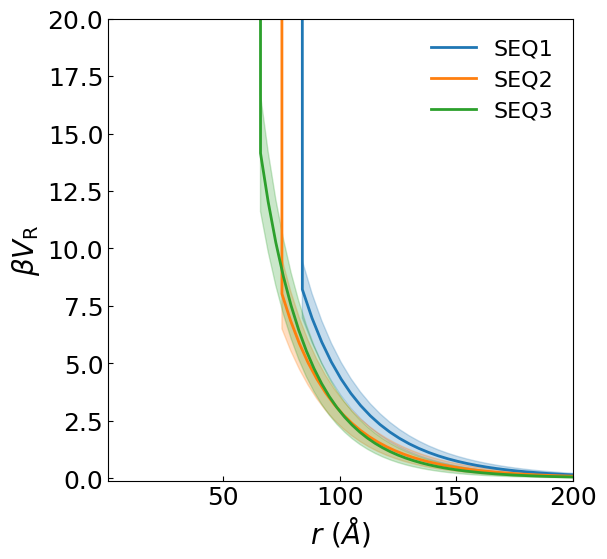

In [22]:
seq_list = ['SEQ1', 'SEQ2', 'SEQ3']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

color_list = ['C0', 'C1', 'C2', 'C3', 'C4']

rr = np.linspace(0.01, 10.0, 200)
ur_hc = 4 * 500 * ((2**(1/6) / rr)**12 - (2**(1/6) / rr)**6 - 0.25)
ur_hc[rr >= 1] = 0

# Load the results from the JSON file
with open('results_dict.txt', 'r') as file:
    results_dict = json.load(file)

for i, seq in enumerate(seq_list):
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-100.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]

    # Extract the fitted parameters and covariance matrix for the current sequence
    params_fit = {key: float(str(value).split('value=')[1].split(' +/-')[0]) for key, value in results_dict[seq]['params_fit'].items()}
    cov = np.array(results_dict[seq]['cov'])

    # Convert params_fit to a dictionary
    fp = [params_fit['phi'], params_fit['kappa'], np.log(params_fit['A'])]
    cov = np.array(results_dict[seq]['cov'])

    # Calculate the standard deviation from the covariance matrix
    fp_std = np.sqrt(np.diag(cov))

    ur_NN, ur_NN_std = sample_potential(fp, fp_std)
    
    sigma = params_fit['sigma']

    ax.fill_between(rr*sigma, ur_NN + ur_NN_std, ur_NN - ur_NN_std, color=color_list[i], alpha=0.25)
    ax.plot(rr*sigma, ur_NN, color=color_list[i], label=f'{seq}', lw=2)

ax.set_xlim(0.85, 200)
ax.set_ylim(-0.1, 20)
ax.set_xlabel(r'$r\ (\AA)$', fontsize=20)
ax.set_ylabel(r'$\beta V_\mathrm{R}$', fontsize=20)

# ax.set_yscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=16, frameon=False)

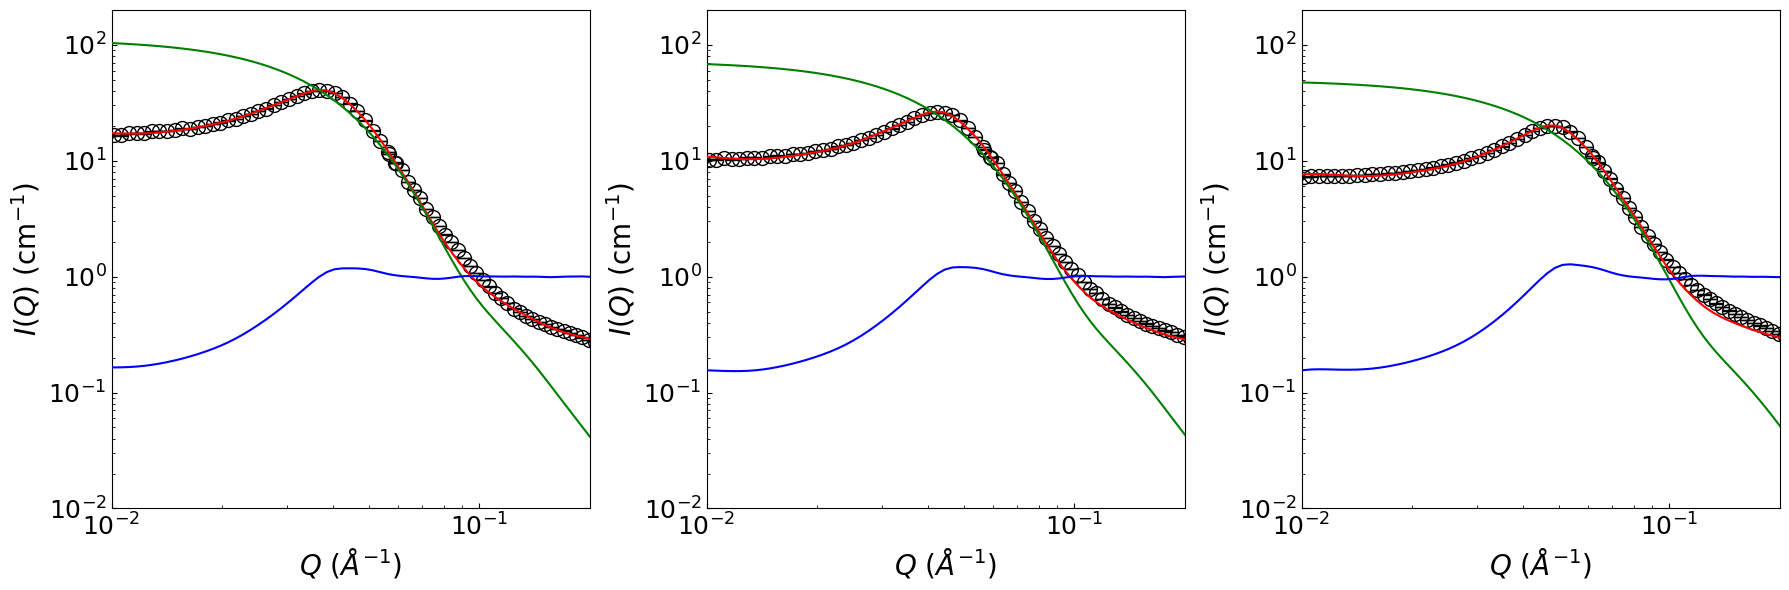

In [23]:
seq_list = ['SEQ1', 'SEQ2', 'SEQ3']

fig = plt.figure(figsize=(18, 6))


color_list = ['C0', 'C1', 'C2', 'C3', 'C4']

# Load the results from the JSON file
with open('results_dict.txt', 'r') as file:
    results_dict = json.load(file)
    
for i, seq in enumerate(seq_list):
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-100.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]

    # Extract I_fit
    I_fit = results_dict[seq]['I_fit']
    Q_fit = results_dict[seq]['Q_fit']
    P_fit = results_dict[seq]['P_fit']
    S_fit = results_dict[seq]['S_fit']
    
    ax = plt.subplot(1, 3, i+1)
    ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='ok', markersize=10, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5)  
    ax.plot(q_data, I_fit, 'r-', zorder=10)
    ax.plot(q_data, P_fit, 'g-', label=r'$CP(Q)$', zorder=10)
    ax.plot(q_data, S_fit, 'b-', label=r'$S(Q)$', zorder=10)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.01, 0.2])
    ax.set_ylim([1e-2, 2e2])  
    
    ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
    ax.set_ylabel(r'$I(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

    # ax.set_yscale('log')
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
plt.tight_layout()

In [25]:
I_fit

'[12.88783229 13.82937157 14.69476967 15.48352806 16.25425674 16.87621651\n 17.30343764 17.5289195  17.58418931 17.52496119 17.41143834 17.2907215\n 17.19239632 17.13663116 17.13821994 17.20664053 17.34497608 17.55024707\n 17.81602207 18.13643225 18.50874744 18.93261275 19.41006254 19.94774194\n 20.55911806 21.26559227 22.09353475 23.0662359  24.19532702 25.47986176\n 26.91023973 28.47624617 30.17524102 32.00786258 33.97159513 36.04517493\n 38.11922536 39.89667063 40.84035189 40.33522223 38.2017802  34.82485263\n 30.80166363 26.63403915 22.56410842 18.6542269  15.1798492  12.1990473\n 11.61500553  9.73030002  9.59374105  8.02554735  6.62853472  5.41438734\n  4.39971058  3.56102173  2.88682953  2.35880804  1.95081572  1.63516328\n  1.38695431  1.18945137  1.03168619  0.90685564  0.80902681  0.73172869\n  0.66863364  0.61574302  0.56966999  0.52878998  0.4925947   0.46022462\n  0.43110746  0.40502737  0.38203624  0.36225061  0.34564902  0.33169476\n  0.31986633  0.30953449  0.3005943   0